In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import datetime
import pickle
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torcheval.metrics import BinaryAUROC

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_pickle('/home/rouse_ai/nha/KLTN/ratings.pickle')

In [4]:
df['rating'] = df['rating'].map(lambda x: 0 if x<4 else 1)
# df['rating'] = df['rating'] - 3

In [5]:
df

,userIDX,movieIDX,rating
0,0,1176,1
1,0,655,0
2,0,902,0
3,0,3339,1
4,0,2286,1
...,...,...,...
1000204,6039,1075,0
1000205,6039,1078,1
1000206,6039,558,1
1000207,6039,1080,1


In [6]:
num_users = df['userIDX'].max() + 1
num_movies = df['movieIDX'].max() + 1

In [7]:
density = len(df) / (num_users * num_movies) *100
density

4.264679797998748

In [8]:
data_train, data_test = train_test_split(df.values, test_size=0.12, random_state=69)
del df

In [9]:
class MovieDataset(Dataset):

    def __init__(self, data, transform=None):
        self.ratings = data

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):

        user_id_ = self.ratings[idx, 0]
        movie_id_ = self.ratings[idx, 1]
        label_ = self.ratings[idx, -1]

        user_id_ = torch.tensor(user_id_, dtype=torch.int32)
        movie_id_ = torch.tensor(movie_id_, dtype=torch.int32)
        label_ = torch.tensor(label_, dtype=torch.float32)

        # sample = {'user_idx':user_id_, "movie_idx": movie_id_, 'label':label_}
        
        return user_id_, movie_id_, label_

In [10]:
class ProbToBinary(nn.Module):
    def __init__(self, threshold=0.5):
        super(ProbToBinary, self).__init__()
        self.threshold = threshold
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(x)
        x[torch.where(x < self.threshold)[0]] = 0
        x[torch.where(x > self.threshold)[0]] = 1
        return x

In [11]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, num_factors):
        """
        Deep Factorization Machine model

        Args:
            size_vector_onehot (int): size vector onehot
            num_og_feature (int): num original features
            num_factors (int): size of latent vector
        """

        super(MatrixFactorization, self).__init__()

        self.user_embedding = nn.Embedding(num_users, num_factors)
        self.item_embedding = nn.Embedding(num_items, num_factors)
        self.user_bias_embedding = nn.Embedding(num_users, 1)
        self.item_bias_embedding = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.randn(1))

        self.flatten = nn.Flatten(start_dim=1, end_dim=- 1)


    def forward(self, user_indices, item_indices):
        """
        Args:
            user_indices (array like): batch of user indexes
            item_indices (array like): batch of item indexes

        Returns:
              feature (torch.Tensor) : (batch_size, num_factors)
        """
        user_embeddings = self.user_embedding(user_indices)
        item_embeddings = self.item_embedding(item_indices)

        user_bias = self.user_bias_embedding(user_indices)[:,0]
        item_bias = self.item_bias_embedding(item_indices)[:,0]

        preds = torch.diag(torch.matmul(user_embeddings, torch.transpose(item_embeddings, 0, 1)))
        preds = preds + user_bias + item_bias + self.global_bias
        # preds = torch.clip(preds, min=-2, max=2)

        return preds


In [12]:
batch_size = 768
dataset_train = MovieDataset(data=data_train)
dataset_test = MovieDataset(data=data_test)
loaders = {'train': DataLoader(dataset_train, batch_size, num_workers=10, shuffle=True),
          'val': DataLoader(dataset_test, batch_size, num_workers=10, shuffle=False)}

In [13]:
num_factors=20
model = MatrixFactorization(num_users=num_users, num_items=num_movies, num_factors=num_factors)
model = model.to(DEVICE)
ptb = ProbToBinary()

In [14]:
def lr_base_on_epoch(epoch:int):
    if epoch <=5:
        gamma = 0.11
    elif epoch <=10:
        gamma = 0.01
    elif epoch <=20:
        gamma = 1e-3
    elif epoch <=30:
        gamma = 5e-4
    elif epoch <=40:
        gamma = 1e-4
    else:
        gamma = 2e-5
    return gamma

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1)
lambda_function = lambda epoch: lr_base_on_epoch(epoch=epoch)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_function)
metric = BinaryAUROC().to(DEVICE)

In [15]:
# model.load_state_dict(torch.load('MF.pth'))
# best_val_score = pickle.load(open('best_val_score.pkl', 'rb'))
best_val_score = 0.

In [16]:
logs = []
first_epoch = True
for epoch in range(51):
    current_log = {'epoch': epoch, 'loss_train': 0., 'loss_val': 0., 'val_acc':0., 'val_AUC':0., 'lr': optimizer.param_groups[0]["lr"]}
    start_time = time.time()
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        for sample_batched in loaders[phase]:
            optimizer.zero_grad()

            user_indices, movie_indices, label = sample_batched
            user_indices = user_indices.to(DEVICE)
            movie_indices = movie_indices.to(DEVICE)
            label = label.type(torch.float32).to(DEVICE)
            pred = model(user_indices, movie_indices)  
            loss = criterion(pred, label)

            current_log[f"loss_{phase}"] += loss.item() * batch_size
            with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            if phase == 'val':
                metric.update(pred, label)
                current_log['val_acc'] += (ptb(pred)==label).type(torch.float32).sum(0).item()
        current_log[f"loss_{phase}"] /= len(loaders[phase].dataset)
    current_log['val_acc'] /= len(loaders['val'].dataset)
    current_log['val_AUC'] = metric.compute().item()
    scheduler.step()
    
    if current_log['val_acc'] > best_val_score:
        torch.save(model.state_dict(), 'MF.pth')
        best_val_score = current_log['val_acc']
    else:
        if first_epoch==False:
            if epoch < 20:
                if (best_val_score - current_log['val_acc']) > 0.04:
                    model.load_state_dict(torch.load('MF.pth'))
            else:
                if (best_val_score - current_log['val_acc']) > 0.02:
                    model.load_state_dict(torch.load('MF.pth'))

    print(f'Epoch {epoch}   train loss: {current_log["loss_train"]:.4f}  -  val loss: {current_log["loss_val"]:.4f}  -  val accuracy: {current_log["val_acc"]:.4f}  -  val ROC AUC: {current_log["val_AUC"]:.4f}  -  lr: {optimizer.param_groups[0]["lr"]}  -  time: {str(time.time()-start_time)}')
    logs.append(current_log)
pickle.dump(logs, open(f'logs_MF{num_factors}_{str(datetime.datetime.now())}.pkl', 'wb'))

Epoch 0   train loss: 1.2723  -  val loss: 1.4055  -  val accuracy: 0.6503  -  val ROC AUC: 0.6886  -  lr: 0.11  -  time: 6.135725498199463
Epoch 1   train loss: 1.4095  -  val loss: 1.4703  -  val accuracy: 0.6512  -  val ROC AUC: 0.6908  -  lr: 0.11  -  time: 6.353124618530273
Epoch 2   train loss: 1.4108  -  val loss: 1.4778  -  val accuracy: 0.6556  -  val ROC AUC: 0.6924  -  lr: 0.11  -  time: 6.868669271469116
Epoch 3   train loss: 1.4068  -  val loss: 1.5057  -  val accuracy: 0.6568  -  val ROC AUC: 0.6933  -  lr: 0.11  -  time: 6.035053014755249
Epoch 4   train loss: 1.4230  -  val loss: 1.5294  -  val accuracy: 0.6550  -  val ROC AUC: 0.6936  -  lr: 0.11  -  time: 5.467753171920776
Epoch 5   train loss: 1.4290  -  val loss: 1.5258  -  val accuracy: 0.6618  -  val ROC AUC: 0.6943  -  lr: 0.01  -  time: 5.722614049911499
Epoch 6   train loss: 0.9532  -  val loss: 0.9676  -  val accuracy: 0.7032  -  val ROC AUC: 0.7002  -  lr: 0.01  -  time: 5.287935256958008
Epoch 7   train loss

In [18]:
import matplotlib.pyplot as plt

In [19]:
loss_trains = np.asarray([logs[i]['loss_train'] for i in range(len(logs))])
loss_vals = np.asarray([logs[i]['loss_val'] for i in range(len(logs))])
val_accs = np.asarray([logs[i]['val_acc'] for i in range(len(logs))])
lrs = np.asarray([logs[i]['lr'] for i in range(len(logs))])

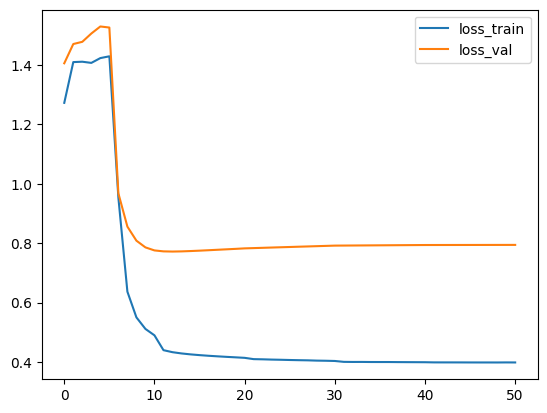

In [20]:
plt.plot(loss_trains, label='loss_train')
plt.plot(loss_vals, label='loss_val')

plt.legend()

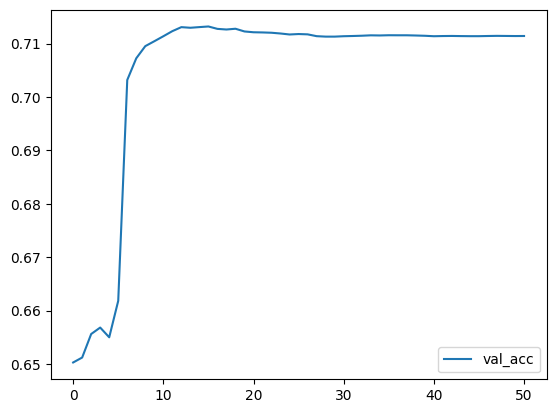

In [21]:
plt.plot(val_accs, label='val_acc')
plt.legend()

In [22]:
best_val_score

0.7132038058420676